# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

In [37]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"\u03C1 = {r:.2f}\np = {p:.2f}", #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# Load C14 models

In [5]:
import c14_models

# Read patient data

In [6]:
exp_data = pd.read_pickle('../../data/C14data_liver_samples_20180505.pkl')

In [7]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,N,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,N,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,N,58.333333,True


In [8]:
exp_data.describe()

,Dbirth,Dcoll,d14C,subject_age
count,82.000000,82.000000,82.000000,82.000000
mean,1962.111789,2016.372967,0.043597,54.261179
std,19.893226,2.980165,0.024579,19.566788
min,1932.583333,2004.833333,0.005100,20.000000
25%,1946.500000,2016.750000,0.026391,37.500000
50%,1958.750000,2017.166667,0.040768,58.250000
75%,1979.833333,2017.416667,0.051775,67.062500
max,1997.333333,2017.583333,0.135400,84.666667


# Plot data 

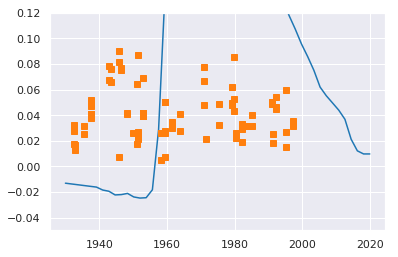

In [9]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [10]:
# @np.vectorize
# def I1(Dbirth, Dcoll, loglam):
#     if loglam <= 10:
#         lam = np.exp(loglam)
#         return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]
#     else:
#         return c14_models.C_atm(Dcoll)
    
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.C_scenario_A(Dbirth, Dcoll, lam)
    else:
        return c14_models.C_atm(Dcoll)

def diffI1(loglam, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    loglam)
    diff = (model_data - data['d14C'])
    return diff

def SSE_individual(p, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    p)
    sse = np.sum((model_data - data['d14C'])**2)
    return sse    

def plot_diffI1(loglammin, loglammax, data):
    loglams = np.linspace(loglammin, loglammax)
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)

    plt.plot(loglams, diff)
    plt.plot([loglammin, loglammax], [0, 0])

def individual_rate(i, loglam0=np.log(0.1)):
    try:
#         return np.exp(sp.optimize.brentq(diffI1, -8, 10, args=exp_data.iloc[i]))
        return np.exp(sp.optimize.newton(diffI1, loglam0, args=([exp_data.iloc[i]])))
    except:
        return np.nan
    
def individual_rate_SSE(i):
    r = np.exp(
            sp.optimize.minimize(
                SSE_individual, np.log(1/10), args=(exp_data.iloc[i]), method='Nelder-Mead'
            )['x'][0]
        )
    return r

## Calculate rates

In [11]:
exp_data['individual_rate'] = [individual_rate_SSE(i) for i in range(len(exp_data))]

In [12]:
exp_data['individual_rate2'] = [individual_rate(i) for i in range(len(exp_data))]

/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 1261.4446131586174 reached
  warnings.warn(msg, RuntimeWarning)
/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 241.00408511880505 reached
  warnings.warn(msg, RuntimeWarning)
/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 15956.333666239048 reached
  warnings.warn(msg, RuntimeWarning)


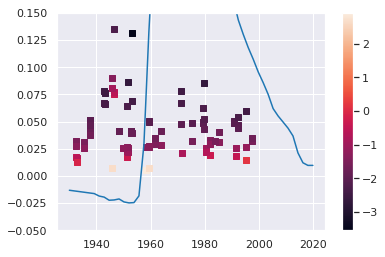

In [13]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=np.log(exp_data['individual_rate']))
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

## Compare to graphical solution

In [14]:
for i, data in exp_data.iterrows():
    plt.figure()
    plot_diffI1(-15, 10, data)
    plt.plot(2*[np.log(data['individual_rate'])], plt.ylim())
    plt.xlabel('lambda')
    plt.ylabel('C14 difference')
    plt.tight_layout()
    plt.savefig('../../results/plots/individual_rate/{}.png'.format(i))
    plt.close()

## Checking the results:

### No nas for SSE:

In [15]:
exp_data[exp_data['individual_rate'].isna()]

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid,individual_rate,individual_rate2


### Some very high rates:

In [16]:
exp_data.query('individual_rate > 2')

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid,individual_rate,individual_rate2
62,hepatocyte,PH79,HL#6,1958.166667,2017.416667,0.0051,T,59.250000,True,18.445633,inf
64,hepatocyte,PH82,HL#8,1959.333333,2017.500000,0.0074,T,58.166667,True,14.346246,3.394050e+168
81,HNF4α -,PH107,HL#9,1945.833333,2017.500000,0.0074,T,71.666667,True,14.346246,0.000000e+00


In [17]:
exp_data.loc[exp_data.query('individual_rate > 2').index, 'individual_rate'] = np.nan

### Very low rates:

In [18]:
exp_data.query('1/individual_rate > 15')

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid,individual_rate,individual_rate2
23,non-hepatocyte,PH32,ND402,1953.0,2017.416667,0.131107,N,64.416667,True,0.02903,NaN


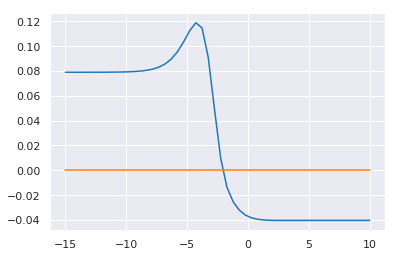

In [19]:
plot_diffI1(-15, 10, exp_data.loc[65])

In [20]:
exp_data.loc[23, 'individual_rate'] = np.nan

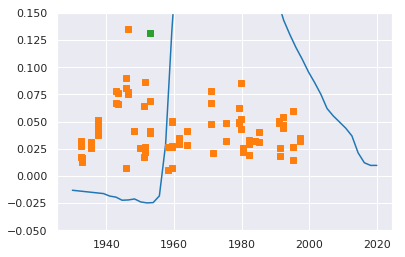

In [21]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], marker='s', ls='None')
plt.plot(exp_data.loc[23, 'Dbirth'], exp_data.loc[23, 'd14C'], marker='s', ls='None')
plt.ylim(-0.05, 0.15)
plt.show()

One of the pre-bomb guys has this very slow turnover. Why does the other pre-bomb guy not have it?

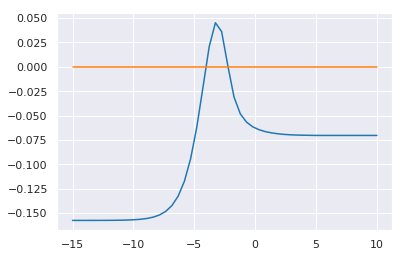

In [22]:
prebomb2 = exp_data.loc[exp_data['d14C'].idxmax()]
plot_diffI1(-15, 10, prebomb2)

### Sanity check of the results by comparing the two methods:

In [23]:
exp_data.query('(individual_rate - individual_rate2)**2 > (1e-3)**2')

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid,individual_rate,individual_rate2


## Analysing results

I use the values obtained with the SSE method.

In [24]:
exp_data['cell_age'] = 1. / exp_data['individual_rate']

In [25]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid,individual_rate,individual_rate2,cell_age
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,N,73.583333,True,0.087163,0.087163,11.472762
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,N,25.416667,True,0.346924,0.346932,2.882476
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,N,31.250000,True,0.183350,0.183354,5.454045
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,N,34.416667,True,0.730628,0.730631,1.368686
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,N,58.333333,True,0.707548,0.707542,1.413332


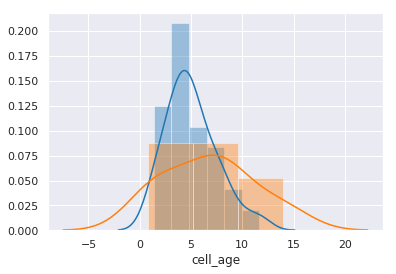

In [26]:
sns.distplot(exp_data.query('valid and type == "hepatocyte"')['cell_age'].dropna())
sns.distplot(exp_data.query('valid and type == "non-hepatocyte"')['cell_age'].dropna())
plt.show()

In [27]:
exp_data[['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C']].corr()

,cell_age,subject_age,Dbirth,Dcoll,d14C
cell_age,1.000000,-0.037340,0.063573,0.179105,0.694379
subject_age,-0.037340,1.000000,-0.988728,-0.034297,0.032106
Dbirth,0.063573,-0.988728,1.000000,0.183542,-0.106942
Dcoll,0.179105,-0.034297,0.183542,1.000000,-0.503060
d14C,0.694379,0.032106,-0.106942,-0.503060,1.000000


In [28]:
exp_data['late'] = pd.Categorical(exp_data['Dcoll'] > 2015)

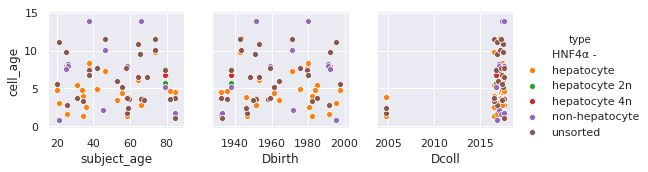

In [29]:
sns.pairplot(exp_data.query('valid'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age'],
            hue = 'type')
plt.show()

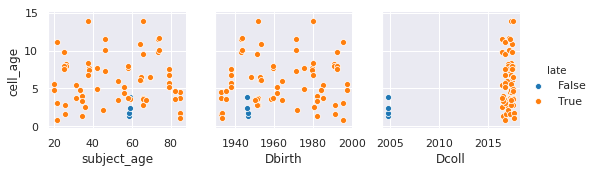

In [30]:
sns.pairplot(exp_data.query('valid'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

## Grouping samples

In [31]:
rate_data = exp_data.query('valid').dropna(
    subset=['cell_age']).groupby(
    ['type', 'code', 'sample']
).mean().dropna(how='all').reset_index()

rate_data['late'] = pd.Categorical(rate_data['Dcoll'] > 2015)

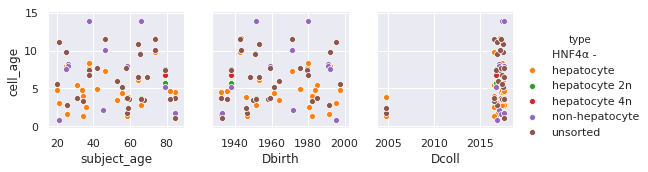

In [35]:
g = sns.pairplot(rate_data,
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age'],
            hue = 'type')
plt.show()

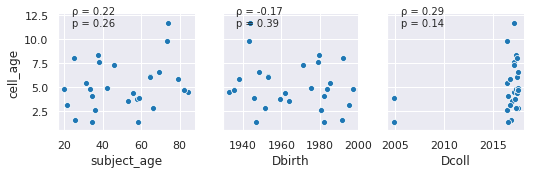

In [38]:
g = sns.pairplot(rate_data.query('type == "hepatocyte"'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age'])
g.map(corrfunc)
plt.show()

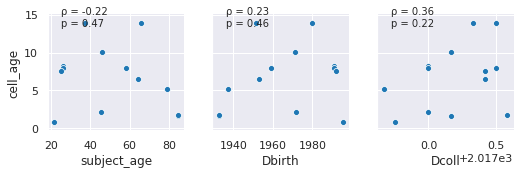

In [39]:
g = sns.pairplot(rate_data.query('type == "non-hepatocyte"'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age'])
g.map(corrfunc)
plt.show()

# Export

In [40]:
# exp_data.to_excel('./write/C14_data.xlsx')